# Импорт библиотек

In [ ]:
%tensorflow_version 1.x
# Импортируем сам keras
import keras
# Последовательный тип модели
from keras.models import Sequential
# Импортируем полносвязный слой, слои активации и слой, превращающий картинку в вектор
from keras.layers import Dense, Activation, Flatten
# Импортируем сверточный слой, max-пулинг слой и слой, выключающий часть нейронов
from keras.layers import Conv2D, MaxPooling2D, Dropout

# Импортируем датасеты
import keras.datasets

import numpy as np
from matplotlib import pyplot as plt

# Эти библиотеки отключают лишние предупреждения от библиотек, в частности,
# tensorflow, чтобы не засорять вывод наших результатов
import warnings
warnings.filterwarnings("ignore")

# keras является оболочкой для более низкоуровневых библиотек, 
# в нашем случае мы используем tensorflow, у которого на данный момент 
# поддерживаются две версии, установим первую
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

TensorFlow 1.x selected.


Using TensorFlow backend.


Instructions for updating:
non-resource variables are not supported in the long term


### Utils

Здесь некоторые дополнительные функции, которые облегчат нам работу с данными (в основном для вывода изображений).

In [ ]:
def plot_dataset_samples_grid(image_data, dataset_name='', N=8):
  """
    Эта функция строит NxN сэмплов из датасета image_data

    Параметры
    ----------
    image_data : array
        Array of shape 
        (number_of_samples, image_width, image_height, number of channels)
        with images
    dataset_name : str
        Name of dataset to write in the title
    N : int
        Size of grid of samples 
  """
  plt.figure(figsize=(10,10))
  data1=image_data[:N*N]
  
  image_width=image_data.shape[1]
  image_heigth=image_data.shape[2]

  if len(data1.shape)==4:
    image_channels=image_data.shape[3]
    data1 = data1.reshape(N, N,image_width,image_heigth, image_channels)
    data1 = np.transpose(data1,(0,2,1,3,4))
    data1 = data1.reshape(N*image_width,N*image_heigth,image_channels)
    plt.imshow(data1)

  elif len(data1.shape)==3:
    data1 = data1.reshape(N, N,image_width,image_heigth)
    data1 = np.transpose(data1,(0,2,1,3))
    data1 = data1.reshape(N*image_width,N*image_heigth)
    plt.imshow(data1,cmap='gray')
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.title('First '+ str(N*N) + ' '+dataset_name+ ' samples of training set')
  plt.show()

def plot_CIFAR_samples(image_data, label_data, classes,  N=8):
  """
    Эта функция строит N сэмплов каждого класса из датасета image_data

    Параметры
    ----------
    image_data : array
        Array of shape 
        (number_of_samples, image_width, image_height, number of channels)
        with images
    label_data : array
        Array of shape 
        (number_of_samples, )
        with labels
    classes : dict
        Dictionary {class_number:class_name}
    dataset_name : str
        Name of dataset to write in the title
    N : int
        Number of samples for each class 
  """
  plt.figure(figsize=(10,N))
  num_classes = len(classes.keys())
  for i,key in enumerate(classes.keys()):
      idxs = np.flatnonzero(label_data == key)
      idxs = np.random.choice(idxs, N, replace=False)
      for i, idx in enumerate(idxs):
          plt_idx = i * num_classes + key + 1
          plt.subplot(N, num_classes, plt_idx)
          plt.imshow(image_data[idx].astype('uint8'))
          plt.axis('off')
          if i == 0:
              plt.title(classes[key])
  plt.show()

from os import listdir, sep
from os.path import abspath, basename, isdir
def tree(dir, padding= '  ', print_files=False):
    """
    Эта функция строит дерево поддиректорий и файлов для заданной директории

    Параметры
    ----------
    dir : str
        Path to needed directory
    padding : str
        String that will be placed in print for separating files levels
    print_files : bool
        "Print or not to print" flag
    """
    cmd = "find '%s'" % dir
    files = os.popen(cmd).read().strip().split('\n')
    padding = '|  '
    for file in files:
        level = file.count(os.sep)
        pieces = file.split(os.sep)
        symbol = {0:'', 1:'/'}[isdir(file)]
        if not print_files and symbol != '/':
            continue
        print (padding*level + pieces[-1] + symbol)

def plot_cats_dogs_samples(train_dir, N=4):
  """
    Эта функция строит N самплов каждого класса из датасета Cats vs Dogs

    Параметры
    ----------
    train_dir : str
        Directory with train Cats vs Dogs dataset
    N : int
        Number of samples for each class 
  """
  import random
  fig, ax = plt.subplots(2,N,figsize=(5*N,5*2))

  for i,name in enumerate(['cat','dog']):
    filenames = os.listdir(os.path.join(train_dir,name))
    
    for j in range(N):
      sample = random.choice(filenames)
      image = load_img(os.path.join(train_dir,name,sample))
      ax[i][j].imshow(image)
      ax[i][j].set_xticks([])
      ax[i][j].set_yticks([])
      ax[i][j].set_title(name)
  plt.grid(False)
  plt.show()

def load_special_images():
  """
    Эта функция загружает 3 картинки для темы бинарной классификации кошек
    и собак

    Returns
    ----------
    im1, im2, im3 : array
        Three images in a form of numpy array
  """
  import requests
  from PIL import Image
  
  image_url_1 = 'https://preview.redd.it/4j8gx4ztzex01.png?width=960&crop=smart&auto=webp&s=5e80ab0071d56cc042f7b709648de8cde394832a'
  image_url_2 = 'https://cdn.images.express.co.uk/img/dynamic/128/590x/secondary/Viral-cat-sensation-715546.jpg'
  image_url_3 = 'https://www.sunnyskyz.com/uploads/2016/12/hmm9j-dog-or-cat-2.jpg'

  im1 = Image.open(requests.get(image_url_1, stream=True).raw)
  im1 = np.array(im1)
  im2 = Image.open(requests.get(image_url_2, stream=True).raw)
  im2 = np.array(im2)
  im3 = Image.open(requests.get(image_url_3, stream=True).raw)
  im3 = np.array(im3)

  return im1, im2, im3

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ 
    Эта функция показывает 6 картинок с предсказанными и настоящими классами
    """
    label_dict={0.:'cat',1.:'dog'}
    n = 0
    nrows = 5
    ncols = 5
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(15,10))
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((224,224,3)),cmap='gray')
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(label_dict[pred_errors[error]],label_dict[obs_errors[error]]))
            n += 1
    plt.tight_layout()

def image_to_batch(img, size=150):
  """ 
    Эта функция переводит картинку размером (img_width,img_height, 3) в батч
    размером (1,size,size,3)

    Parameters
    ----------
    img : array
        Image of size (img_width,img_height, 3)
    
    size : int
        Size of image in batch
    
    Returns
    ----------
    img_resized : array
        Batch of one image with shape (1,size,size,3)
  """
  import cv2
  img_resized=cv2.resize(img,(size,size)).reshape(1,size,size,img.shape[2])
  return img_resized

def plot_special_images(pred1,pred2,pred3):
  """
    Эта функция строит 3 специальные картинки для датасета Cats vs Dogs
    с предсказаниями класса

    Параметры
    ----------
    pred1,pred2,pred3  : arrays
        Arrays of shape one with probability of image to be of class 1
  """
  im1, im2, im3 = load_special_images()

  pred1 = np.asscalar(pred1)
  pred2 = np.asscalar(pred2)
  pred3 = np.asscalar(pred3)

  preds=[pred1,pred2,pred3]

  fig, ax = plt.subplots(1,3,figsize=(15,10))

  ax[0].imshow(im1)
  ax[1].imshow(im2)
  ax[2].imshow(im3)

  for i in range(3):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    if preds[i]>0.5:
      ax[i].set_title('Это собака с вероятностью\n%.f проц.' % (preds[i]*100))
    else:
      ax[i].set_title('Это кошка с вероятностью\n%.f проц.' % ((1-preds[i])*100))


  plt.grid(False)
  plt.show()

def get_test_predictions(test_generator, model, dataset_len=2500):
  """
    Эта функция вытаскивает из генератора все предсказания

    Параметры
    ----------
    test_generator  : ImageDataGenerator
        Generator, producing batches (img, label)
    model : keras.model
        Model for getting predictions
    dataset_len : int
        Number of samples in generator
    
    Returns
    ----------
    preds_labels  : array
        Predicted labels
    preds_vec : array
        Predicted probabilities
    labels_vec : array
        True labels
    datas_vec : array
        Array of images
  """
  labels=[]
  preds=[]
  datas=[]

  samples=0
  for i,batch in enumerate(test_generator):
    data, label=batch
    labels.append(label)
    preds.append(model.predict(data))
    datas.append(data)
    samples+=len(data)
    if samples>=dataset_len:
      break

  labels_vec=np.hstack(labels)
  preds_vec=np.hstack([pred.reshape(-1,) for pred in preds])
  datas_vec=np.vstack(datas)
  preds_labels=preds_vec.copy()
  preds_labels[preds_labels<0.5]=0
  preds_labels[preds_labels>=0.5]=1

  return preds_labels, preds_vec, labels_vec, datas_vec

# Загрузка данных

In [ ]:
!wget -c https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
!unzip -qq Cat_Dog_data.zip

--2021-03-01 07:23:19--  https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.107.158
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.107.158|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 580495262 (554M) [application/zip]
Saving to: ‘Cat_Dog_data.zip’

Cat_Dog_data.zip    100%[===================>] 553.60M  46.9MB/s    in 12s     

2021-03-01 07:23:32 (45.0 MB/s) - ‘Cat_Dog_data.zip’ saved [580495262/580495262]



In [ ]:
import os

In [ ]:
base_dir = 'Cat_Dog_data'

train_dir = os.path.join(base_dir, 'train')

test_dir = os.path.join(base_dir, 'test')

In [ ]:
# Соотношение между номером класса и его называнием запишем в словарь
LABEL_DICT={1:'dog',0:'cat'}

# Задание 1



1.   Аугментация данных
2.   Увеличение числа обучаемых параметров


## 1) Улучшить модель

Попробовать улучшить предсказания при помощи 

1.   Aугментации исходных данных (Добавить в ImageDataGenerator различные трансформации)
2.   Увеличения числа обучаемых параметров.

Чем ближе слои модели к выходному слою, тем больше веса зависят от конкретной задачи.

Изначально мы заморозили все слои модели `vgg_model`, теперь можно заморозить, например, первые $15$ слоев, а остальные сделать обучаемыми.



### Аугментация данных

Создадим ImageDataGenerator для трейновой и тестовой выборок,
указав преобразование, нормализующее изображения и еще какой-нибудь набор трансформаций из списка

In [ ]:
# Импортируем нужный нам модель генератора
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
my_datagen = ImageDataGenerator(
        rescale=1./255, # Нормировка

        rotation_range=10,  # Случайно повернуть картинку в диапазоне (0, degrees)
        # Возможные значения - число от 0 до 360 градусов

        width_shift_range=0.1, # Случайно подвинуть картинку по горизонтали на 0.1 ширины
        # Возможные значения - число от -1 до 1 (- влево, + вправо)
        height_shift_range=-0.2,# Случайно подвинуть картинку по вертикали на 0.1 ширины
        # Возможные значения - число от -1 до 1 (- вниз, + вверх)
        
        #shear_range=50,  # Установить случайный диапазон сдвига (деформация)
        # Угол сдвига по часовой стрелке в градусах от 0 до 360

        zoom_range=0.3,  # Увеличение или уменьшение изображения в диапазоне [1-zoom_range,1+zoom_range]
        # от 0 до 1

        horizontal_flip=False,  # случайно отражать картинку по горизонтали
        # True/False
        #vertical_flip=True  # случайно отражать картинку по вертикали
        # True/False
        )

In [ ]:
train_generator = my_datagen.flow_from_directory(
        train_dir,  # Путь к директории с трейновой выборкой
        target_size=(224, 224),  # Размер изображений, к которому нужно привести все данные
        batch_size=128,
        #Генератор автоматически расставит бинарные лейблы для классов cat и dog
        class_mode='binary')


test_generator = my_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=128,
        class_mode='binary')

Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


### Замороженные веса

План по созданию новой модели на основе предобученной **VGG16** с **частью** замороженных весов


1.   Загрузим модель **vgg16** с весами 
2.   Построим сверху свой классификатор (можно скопировать тот, что мы использовали в предыдущей модели)
3.   Заморозим **ЧАСТЬ** весов модели
4.   Скомпилируем модель


In [ ]:
from keras.applications import vgg16 as vgg

In [ ]:
vgg_model = vgg.VGG16(weights='imagenet', 
                       include_top=False)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

58892288/58889256 [==============================] - 3s 0us/step


In [ ]:
#Посмотрим, из чего состоит VGG модель
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

Достанем последний слой `block5_pool` из **VGG** модели.

Сверху него мы далее построим наш классификатор.

In [ ]:
last = vgg_model.get_layer('block5_pool').output

In [ ]:
# Модуль, с помощью которого мы будем "сшивать" последовательные модели
from keras.engine import Model
# Импортируем Pooling по всему слою входных данных и нормализацию батчей
from keras.layers import GlobalAveragePooling2D, BatchNormalization

Построим сверху свой классификатор

In [ ]:
# Добавим новые GAP (вместо FLatten) и BatchNormalization слои
x = GlobalAveragePooling2D()(last)
x = BatchNormalization()(x)

# Привычные полносвязные слои
x = Dense(512, activation='elu')(x)
x = Dense(256, activation='elu')(x)
x = Dropout(0.3)(x)
pred = Dense(1, activation='sigmoid')(x)

Объединим **VGG16** и **классификатор** в одного трансформера при помощи модуля `Model`

In [ ]:
fin_model = Model(vgg_model.input, pred)

Заморозим ЧАСТЬ весов модели, тем самым увеличив число обучаемых параметров

In [ ]:
len(vgg_model.layers)

19

In [ ]:
for layer in vgg_model.layers:
     layer.trainable=False

In [ ]:
for i in range((len(vgg_model.layers))):
  if i<16:
    vgg_model.layers[i].trainable = False
  else:
    vgg_model.layers[i].trainable = True

In [ ]:
for layer in vgg_model.layers:
     print(layer.trainable)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True


In [ ]:
# Скомпилируем модель с функцией ошибки binary crossentropy, оптимизатором Адам 
# (оптимизатор, который со стандартным набором параметров может обучить эффективную
# нейросеть), и метрикой - количеством правильно угаданных картинок.
fin_model.compile(loss='binary_crossentropy',
                  optimizer = 'adam',
                  metrics = ['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
fin_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

Запустим обучение полученной модели с нашими генераторами 
с дополнительными трансформациями.

Обратите внимание, что за счет того, что у нас увеличилось количество тренируемых параметров и добавились трансформации, процесс тренировки ощутимо замедлился, за все в жизни надо платить :(

In [ ]:
from datetime import datetime

In [ ]:
# Поставим модель обучаться 5 эпох при помощи модуля fit_generator
print('Врямя начала обучения',datetime.now())
print('----------------------------------------------------')
history_cnn = fin_model.fit_generator(train_generator,
              epochs=5,
              validation_data=test_generator,
              shuffle=True)
print('Врямя окончания обучения',datetime.now())

Врямя начала обучения 2021-03-01 07:24:54.156030
----------------------------------------------------

Epoch 1/5
176/176 [==============================] - 369s 2s/step - loss: 0.2150 - accuracy: 0.9084 - val_loss: 0.1329 - val_accuracy: 0.9304
Epoch 2/5
176/176 [==============================] - 332s 2s/step - loss: 0.1499 - accuracy: 0.9384 - val_loss: 0.4405 - val_accuracy: 0.8460
Epoch 3/5
176/176 [==============================] - 333s 2s/step - loss: 0.1262 - accuracy: 0.9475 - val_loss: 0.1881 - val_accuracy: 0.9004
Epoch 4/5
176/176 [==============================] - 329s 2s/step - loss: 0.1142 - accuracy: 0.9534 - val_loss: 0.1076 - val_accuracy: 0.9588
Epoch 5/5
176/176 [==============================] - 325s 2s/step - loss: 0.1025 - accuracy: 0.9582 - val_loss: 0.1566 - val_accuracy: 0.9328
Врямя окончания обучения 2021-03-01 07:53:03.986005


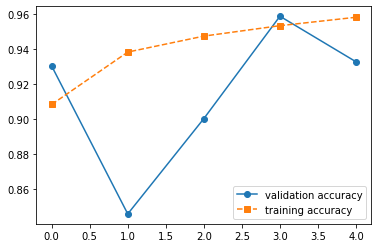

In [ ]:
plt.plot(history_cnn.history['val_accuracy'], '-o', label='validation accuracy')
plt.plot(history_cnn.history['accuracy'], '--s', label='training accuracy')
plt.legend();

In [ ]:
fin_model.evaluate(test_generator)

20/20 [==============================] - 33s 2s/step


[0.14179912209510803, 0.9327999949455261]

#### 2) Проверить поведение модели на особенных случаях

In [ ]:
# Загрузим картинки из описания задачи при помощи функции load_special_images()
im1, im2, im3 = load_special_images()

Изменим размер как у входных данных сети ( 224х224 ) и добавим дополнительную размерность при помощи функции image_to_batch

In [ ]:
im1_224=image_to_batch(im1,224)
im2_224=image_to_batch(im2,224)
im3_224=image_to_batch(im3,224)

Не забудем про нормировку!

In [ ]:
im1_224 = im1_224/255.
im2_224 = im2_224/255.
im3_224 = im2_224/255.

Получим вероятности, что на картинках собаки (используйте метод predict)

In [ ]:
pred1 = fin_model.predict(im1_224)
pred2 = fin_model.predict(im2_224)
pred3 = fin_model.predict(im3_224)

Посмотрим, для какой картинки какое предсказание дала нейросеть при помощи функции plot_special_images

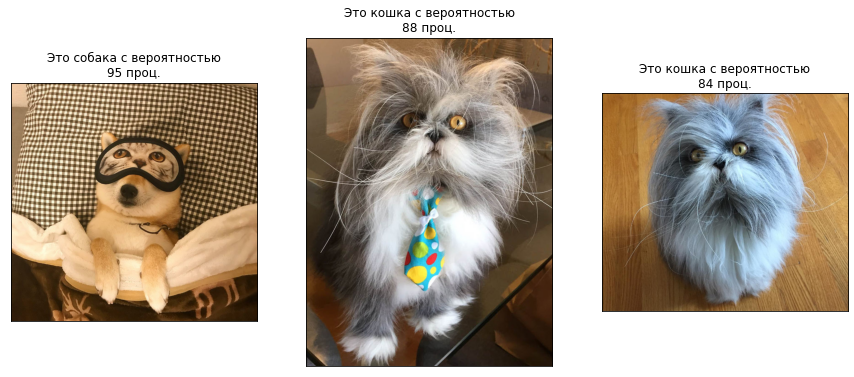

In [ ]:
plot_special_images(pred1,pred2,pred3)

#### 3) Посмотрим на картинки с наибольшей ошибкой

In [ ]:
# Создадим генератор картинок из тестовой выборки
test_generator = my_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=200,
        class_mode='binary',shuffle=False)

Found 2500 images belonging to 2 classes.


In [ ]:
preds_labels, preds_vec, labels_vec, datas_vec = get_test_predictions(test_generator, fin_model)

In [ ]:
errors = labels_vec!=preds_labels

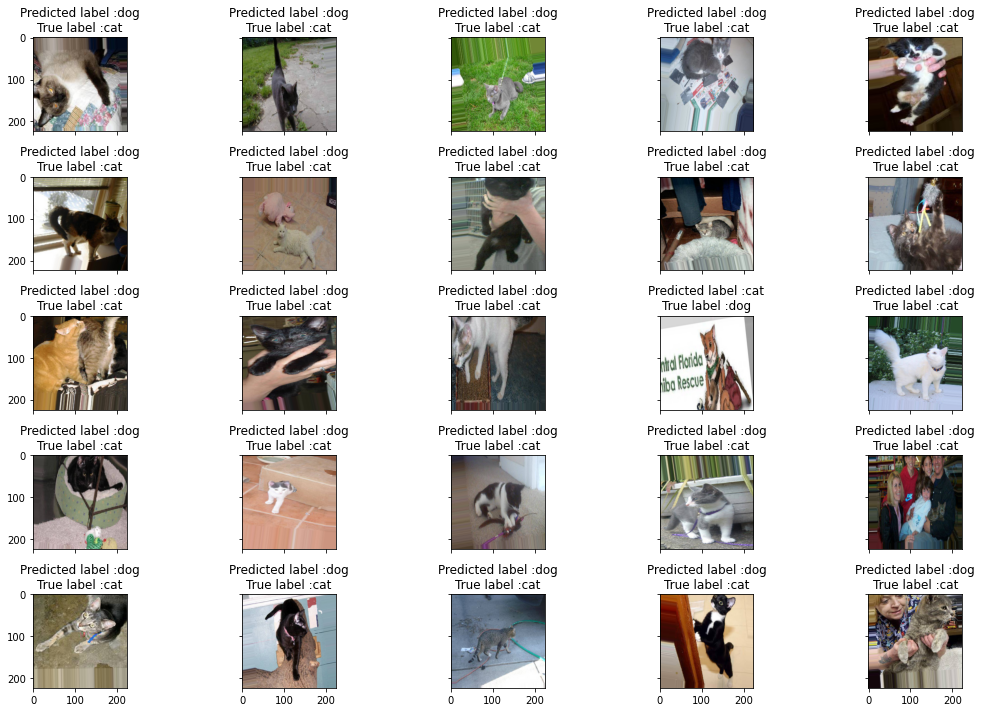

In [ ]:
# Выделим из векторов предсказаний и настоящих лейблов только те,
# где нейросеть допустила ошибку
Y_pred_classes_errors = preds_labels[errors]
Y_pred_errors = preds_vec[errors]
Y_true_errors = labels_vec[errors]
X_val_errors = datas_vec[errors]

# Вероятности неправильно предсказанных классов
Y_pred_errors_prob = Y_pred_errors

# Вероятности, соответствующие правильным классам
true_prob_errors = 1-Y_pred_errors

# Разница вероятностей правильного и неправильного классов
delta_pred_true_errors = np.abs(Y_pred_errors_prob - true_prob_errors)

# Отсортированный списоц разниц вероятностей
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# 25 наибольших ошибок
most_important_errors = sorted_dela_errors[-25:]

# Построим самые ошибочные rfhnbyrb
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)